# Overview of this notebook

This notebook demonstrates the process of reproducing the experiments described in the accompanying paper, "Quantifying Competitive Relationships Among Open-Source Software Projects." The paper proposes a method called MIAO (Mutual Impact Analysis of OSS) to quantify the competitive relationships between OSS projects and predict their survival.

This notebook covers the following key steps of the MIAO methodology and the subsequent analysis:

1.  **Data Preparation:**
    *   **Automatic Detection of Analysis Periods (Tm):** As detailed in the "# Auto detecting Tm" section of this notebook and "Determination of Analysis Period" (Section V-B) of the paper, the analysis periods (Tm) for each OSS project group are automatically determined. The raw activity data (daily commit counts) are sourced from `datasets/original/daily/{org}/{name}.csv`.
    *   **Preprocessing for VAR Analysis:** Corresponding to the "PREPARE\_VAR" function in Algorithm 1 and described in the "# Preparation for VAR Analysis" section of this notebook (and "MIAO Phase 1" (Section III-A) and "Parameter Settings" (Section V-D) of the paper), the time series data for each project ($A_i$) within each analysis period ($T_m$) is preprocessed. This includes:
        *   Seasonal adjustment (STL decomposition for 7-day seasonality).
        *   Stationarity testing (ADF test) and fractional differencing if a unit root is detected.
        *   Optimal lag order selection for the VAR model using AIC (and Ljung-Box test for white noise residuals).
    *   The preprocessed datasets are equivalent to those found in `datasets/preprocessed/{permute_i}/{period_shift}{Tm}{group}.csv`.
    *   **Period Shifts:** To ensure robustness, multiple analysis periods are created by shifting the start time of each Tm, as explained in "# Period shifts" in this notebook and "Period Shift" (Section V-C) of the paper.

2.  **MIAO Execution:**
    *   **SVAR Modeling and IRF Calculation (MIAO Phase 1):** As shown in the "# SVAR" and "# IRF-Calculation" sections of this notebook (and Algorithm 1, "MIAO Phase 1" (Section III-A) and "Parameter Settings" (Section V-D) of the paper), Structural Vector Autoregressive (SVAR) models are estimated for each group of OSS projects (target and two competitors) for each analysis period (Tm) and period shift. Recursive SVAR identification is used, with variable ordering based on REV status and permutations for non-REV cases. Impulse Response Functions (IRFs) are then calculated to quantify the dynamic interactions between the projects. The statistical results of these estimations (ADF tests, VAR parameters, Ljung-Box tests) are summarized in `adf_test_results/{permute_i}.csv` and `var_estimation_results/{permute_i}.csv`.
    *   **MIAO Score Calculation (MIAO Phase 2):** Following the "# MIAO-Score-Calculation" section in this notebook (and "MIAO Phase 2" (Section III-B) of the paper), the calculated IRFs are condensed into MIAO scores (MSij). This involves calculating the Shock Cumulative Effect (SCEij) and then aggregating these across the analysis periods (Tm) to produce the final MSij. For robustness, an Average MIAO Score (AMSij) is computed by averaging MSij values obtained from different period shifts. These scores are stored in `miao_score_tables/{permute_i}/{group}_{n_split}.csv`.

3.  **Decision Tree Analysis (Answering RQ1 & RQ2):**
    *   **Dataset Creation:** The calculated AMSij scores are used as features to create a dataset for a decision tree model, as found in `datasets/decisiontree/{permute_i}.csv`. The target variable is "REV" (Rising Event), indicating whether an OSS project ceased development due to competitive influence.
    *   **Model Training and Evaluation:** As detailed in the "# Decision Tree" section of this notebook (and "Answers to Research Questions" (Section VI-B) of the paper), a decision tree classifier is trained and evaluated using Leave-One-Out Cross-Validation (LOOCV) to predict REV. This step corresponds to answering RQ1: "How accurately can MIAO identify OSS projects that ceased development due to competitive influences?"
    *   **Feature Importance Analysis:** The feature importances from the decision tree model are analyzed to identify the key factors of competitive relationships affecting OSS survival, corresponding to RQ2: "What are the key factors of competitive relationships that affect the survival of OSS projects?"
    *   The classification results are stored in `classification_results/{permute_i}.csv`.

This notebook provides the code and explanations to replicate the findings presented in the paper, offering insights into the competitive dynamics of OSS projects.


## Reproducible Environment

* OS: maxOS Sequoia 15.1 (24B2082)
* Chip: Apple M4 Max
* RAM: 64GB

In [1]:
# If you haven't installed the following packages, you need to install them first
# !pip install -r requirements.txt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from typing import List, Dict
import warnings
import copy
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from statsmodels.tsa.vector_ar.svar_model import SVAR
from statsmodels.stats.contingency_tables import mcnemar
from scipy import stats

from miao import parse_miao_db_yml, auto_detect_tms, create_Tms, \
    prepare_var, miao_phase1_with_period_shifts, miao_phase2_with_period_shifts, get_unique_idx

warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

# Auto detecting $T_m$

The `miao.auto_detect_tms` function automatically detects the "start_date" and "end_date" for each OSS project's analysis. Based on settings of experiment, the maximum analysis period is 4 years, and if the period exceeds this, it will be divided into segments. However, if the last segment is less than 4 years, the analysis start date is set to 4 years before the end date.

For example, if the last period segment is from 2021-01-01 to 2023-01-01, since this is only a 2-year period, the analysis period will be adjusted to span from 2019-01-01 to 2023-01-01.

Note that since projects with analysis periods of less than 4 years are also included in the analysis targets, there exist groups whose analysis periods are not necessarily 4 years.

In [4]:
db = parse_miao_db_yml("./db.yml")

rev_db_permutation_2 = []
rev_db_permutation_3 = []
rev_db_permutation_4 = []
rev_db_permutation_5 = []
rev_db_permutation_6 = []

for row in db:
    if row["rev"] == False:
        # patter 2
        copied = copy.deepcopy(row)
        copied["competitors"][0] = row["competitors"][1]
        copied["competitors"][1] = row["competitors"][0]
        rev_db_permutation_2.append(copied)

        # pattern 3
        copied = copy.deepcopy(row)
        copied["name"] = row["competitors"][1]["name"]
        if "appearance_time" in row["competitors"][1]:
            copied["appearance_time"] = row["competitors"][1]["appearance_time"]
            
        copied["competitors"][0] = {"name": row["name"]}
        copied["competitors"][1] = row["competitors"][0]
        rev_db_permutation_3.append(copied)

        # pattern 4
        copied = copy.deepcopy(row)
        copied["name"] = row["competitors"][1]["name"]
        if "appearance_time" in row["competitors"][1]:
            copied["appearance_time"] = row["competitors"][1]["appearance_time"]
            
        copied["competitors"][0] = row["competitors"][0]
        copied["competitors"][1] = {"name": row["name"]}
        rev_db_permutation_4.append(copied)

        # pattern 5
        copied = copy.deepcopy(row)
        copied["name"] = row["competitors"][0]["name"]
        if "appearance_time" in row["competitors"][0]:
            copied["appearance_time"] = row["competitors"][0]["appearance_time"]
        
        copied["competitors"][0] = {"name": row["name"]}
        copied["competitors"][1] = row["competitors"][1]
        rev_db_permutation_5.append(copied)


        # pattern 6
        copied = copy.deepcopy(row)
        copied["name"] = row["competitors"][0]["name"]
        if "appearance_time" in row["competitors"][0]:
            copied["appearance_time"] = row["competitors"][0]["appearance_time"]
        
        copied["competitors"][0] = row["competitors"][1]
        copied["competitors"][1] = {"name": row["name"]}
        rev_db_permutation_6.append(copied)
    else:
        rev_db_permutation_2.append(copy.deepcopy(row))
        rev_db_permutation_3.append(copy.deepcopy(row))
        rev_db_permutation_4.append(copy.deepcopy(row))
        rev_db_permutation_5.append(copy.deepcopy(row))
        rev_db_permutation_6.append(copy.deepcopy(row))

permutes = [
    db,
    rev_db_permutation_2,
    rev_db_permutation_3,
    rev_db_permutation_4,
    rev_db_permutation_5,
    rev_db_permutation_6,
]

tms_ = []

for db_ in permutes[0]:
    tms = auto_detect_tms(db_)
    tms_.append(tms)

tms_map_permutes = []

for p in permutes:
    tms_map = {}
    n = 0
    for i, db_ in enumerate(p):
        tms = tms_[i]
        idx = get_unique_idx(db_)
        tms_map[idx] = tms
        n += len(tms)
        
    tms_map_permutes.append(tms_map)

for i, m in enumerate(tms_map_permutes):
    print(len(m))

36
36
36
36
36
36


# Preparation for VAR Analysis


The `miao.prepare_var` function corresponds to PREPARE_VAR in the algorithm presented in the paper. prepare_var performs the following processes and returns input variables for VAR with optimal lag and preprocessed $A_i$:

* Extract subsequence $A_{T_m}$ from $A = [A_1, A_2, A_3]$ corresponding to $T_m$
* Apply seasonal adjustment with 7-day periodicity to $A_{T_m}$
* Conduct ADF test on $A_{T_m}$
* Apply fractional differencing if $A_{T_m}$ has unit root
* Search for lag between 1 and 15 that has Ljung-Box test $p \geq 0.1$ and minimum AIC (if none exists, select the * one with minimum AIC)

In [5]:
tms = tms_map_permutes[0]["chainer,tensorflow,pytorch"]
repos = [c["name"] for c in db[0]["competitors"]] + [db[0]["name"]]

T = create_Tms(tms[0]["start"], tms[0]["end"], 12, split_interval=False)

As = []

for repo in repos:
    A = pd.read_csv(f"./datasets/original/daily/{repo}.csv", index_col=0)
    As.append((repo, A))
    
X_each_tm = prepare_var(T, As)
assert(len(X_each_tm) == len(T))

Failed to reject the H0 of whiteness test: pvalue=0.26026209439413395, lag=4, adf_p=0.000, 0.000, 0.016
Failed to reject the H0 of whiteness test: pvalue=0.9037414058396334, lag=10, adf_p=0.000, 0.000, 0.001
Failed to reject the H0 of whiteness test: pvalue=0.34021716228650223, lag=8, adf_p=0.000, 0.000, 0.003
Failed to reject the H0 of whiteness test: pvalue=0.4311435009329473, lag=10, adf_p=0.000, 0.000, 0.011


`X_each_tm` stores input variables (represented as $\mathcal{D}'$ in the paper) to VAR from T1 up to a maximum of T4.

In [6]:
T1_lag, T1_X = X_each_tm[0]
T2_lag, T2_X = X_each_tm[1]
T3_lag, T3_X = X_each_tm[2]
T4_lag, T4_X = X_each_tm[3]

display(T1_X)
display(T2_X)
display(T3_X)
display(T4_X)

,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,44.628868,11.026147,12.399377
2016-09-26,51.154743,9.327045,12.032284
2016-09-27,47.139203,14.478136,11.579621
2016-09-28,45.563818,8.839176,10.030257
2016-09-29,43.418438,11.586757,13.192421
...,...,...,...
2017-09-20,39.521351,20.778812,19.713472
2017-09-21,35.893028,23.268836,17.478096
2017-09-22,38.221514,20.913732,15.996192


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,44.636608,11.047503,12.348567
2016-09-26,51.157936,9.300237,12.084038
2016-09-27,47.119255,14.599319,11.600481
2016-09-28,45.579762,8.815193,9.966478
2016-09-29,43.414560,11.716455,13.349029
...,...,...,...
2018-09-20,46.381797,17.640288,30.845210
2018-09-21,56.970568,14.965439,30.959513
2018-09-22,55.929304,20.087344,28.259031


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,49.168135,20.328901,22.644142
2016-09-26,50.977352,9.904016,13.222944
2016-09-27,52.283343,8.767610,5.232160
2016-09-28,29.803507,-0.751963,2.245335
2016-09-29,49.294349,5.668367,4.142771
...,...,...,...
2019-09-20,104.357536,33.349685,9.631782
2019-09-21,62.115778,31.733385,17.880866
2019-09-22,53.168135,17.328901,15.644142


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-09-25,44.518612,11.041205,12.757546
2016-09-26,51.180095,9.307330,11.385850
2016-09-27,47.798850,14.583310,9.812537
2016-09-28,44.312965,8.820920,10.601808
2016-09-29,43.455679,11.692829,12.837047
...,...,...,...
2020-02-20,99.364999,18.940577,-0.201003
2020-02-21,103.540332,20.129115,-0.595026
2020-02-22,101.401480,22.197809,0.140470


The DataFrame generated by prepare_var is identical to the data output under the datasets/preprocessed directory.

In [7]:
T1_X.sum().sum() == pd.read_csv(f"./datasets/preprocessed/permute_0/original/T1/1_0.csv", index_col=0).sum().sum()

True

## Period shifts

In [8]:
shifts = [pd.DateOffset(months=1), pd.DateOffset(months=2), pd.DateOffset(months=3)]

for shift in shifts:
    print(f"-------------- {shift.months} month(s) shift --------------")
    
    shifted_start = tms[0]["start"] + shift
    shifted_end = tms[0]["end"] + shift

    shifted_T = create_Tms(shifted_start, shifted_end, 12, split_interval=False)

    As = []

    for repo in repos:
        A = pd.read_csv(f"./datasets/original/daily/{repo}.csv", index_col=0)
        As.append((repo, A))

    X_each_tm = prepare_var(shifted_T, As)
    assert(len(X_each_tm) == len(shifted_T))
    lag, X = X_each_tm[0]
    display(X)

-------------- 1 month(s) shift --------------
Failed to reject the H0 of whiteness test: pvalue=0.16258694751940767, lag=2, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.38083850007913905, lag=9, adf_p=0.000, 0.000, 0.040
Failed to reject the H0 of whiteness test: pvalue=0.35880917245070304, lag=8, adf_p=0.000, 0.000, 0.004
Failed to reject the H0 of whiteness test: pvalue=0.4348729169312028, lag=10, adf_p=0.000, 0.000, 0.016


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-10-25,55.279500,3.587672,21.754498
2016-10-26,52.355205,5.354796,12.306325
2016-10-27,48.786291,5.740706,13.695983
2016-10-28,48.077946,7.793749,11.256773
2016-10-29,52.537043,7.316242,7.306260
...,...,...,...
2017-10-20,34.617642,17.999191,10.797471
2017-10-21,40.249214,14.928915,13.198736
2017-10-22,37.043894,17.708182,13.271460


-------------- 2 month(s) shift --------------
Failed to reject the H0 of whiteness test: pvalue=0.9994047559161869, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.922576348485205, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.33842130359837747, lag=8, adf_p=0.000, 0.000, 0.004
Failed to reject the H0 of whiteness test: pvalue=0.372303296890559, lag=10, adf_p=0.000, 0.000, 0.019


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-11-25,-1.068381,0.226837,15.075807
2016-11-26,28.105288,19.204428,9.280289
2016-11-27,35.623496,12.383700,20.053398
2016-11-28,51.700688,11.519662,2.834642
2016-11-29,47.305084,28.939991,5.584642
...,...,...,...
2017-11-20,45.700688,14.519662,3.834642
2017-11-21,39.305084,6.939991,8.584642
2017-11-22,65.954028,6.408910,16.333510


-------------- 3 month(s) shift --------------
Failed to reject the H0 of whiteness test: pvalue=0.9987030291136866, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.9212020554932282, lag=10, adf_p=0.000, 0.000, 0.000
Failed to reject the H0 of whiteness test: pvalue=0.35511890253692496, lag=8, adf_p=0.000, 0.000, 0.008
Failed to reject the H0 of whiteness test: pvalue=0.8023275080304014, lag=14, adf_p=0.000, 0.000, 0.030


,tensorflow/tensorflow,pytorch/pytorch,chainer/chainer
date,,,
2016-12-25,35.568366,16.381091,10.320559
2016-12-26,7.207021,6.918906,-7.836304
2016-12-27,13.716825,14.717225,24.340167
2016-12-28,9.324992,12.090798,6.015829
2016-12-29,13.264552,26.101787,-2.484171
...,...,...,...
2017-12-20,94.324992,17.090798,38.015829
2017-12-21,59.264552,8.101787,60.515829
2017-12-22,49.333072,12.697618,29.569859


# SVAR

The following is code that reads CSV data corresponding to shift, Tm, and group from datasets/preprocessed and estimates SVAR. For lags, it uses the pre-estimated values recorded in var_estimation_result.csv.

In [9]:
shift = "original"
Tm = "T1"
group_with_sep = "1_0"
permute_id = 0

var_result = pd.read_csv(f"./var_estimation_results/permute_{permute_id}.csv")
X = pd.read_csv(f"./datasets/preprocessed/permute_{permute_id}/{shift}/{Tm}/{group_with_sep}.csv", index_col=0)

# A matrix that represent recursive constraint. E will be estimated. 
A = np.array([
    [1, 0, 0],
    ["E", 1, 0],
    ["E", "E", 1]
])

cond = (var_result["group"] == group_with_sep) & (var_result["Tm"] == Tm) & (var_result["period_shift"] == shift)
lag = var_result[cond].iloc[0].lag 

model = SVAR(X, svar_type="A", A=A)
results = model.fit(maxlags=lag)

# IRF Calculation

The impulse response can be calculated using `irf = results.irf(period)`, and in the case of SVAR, the calculation results are stored in `irf.svar_irfs`. When the `irf.plot()` function is called, an n✕n figure is displayed. The shape of svar_irfs is a third-order tensor of dimensions (period, n, n).

In [10]:
# In our paper, period=200.
period = 20
irf = results.irf(period)

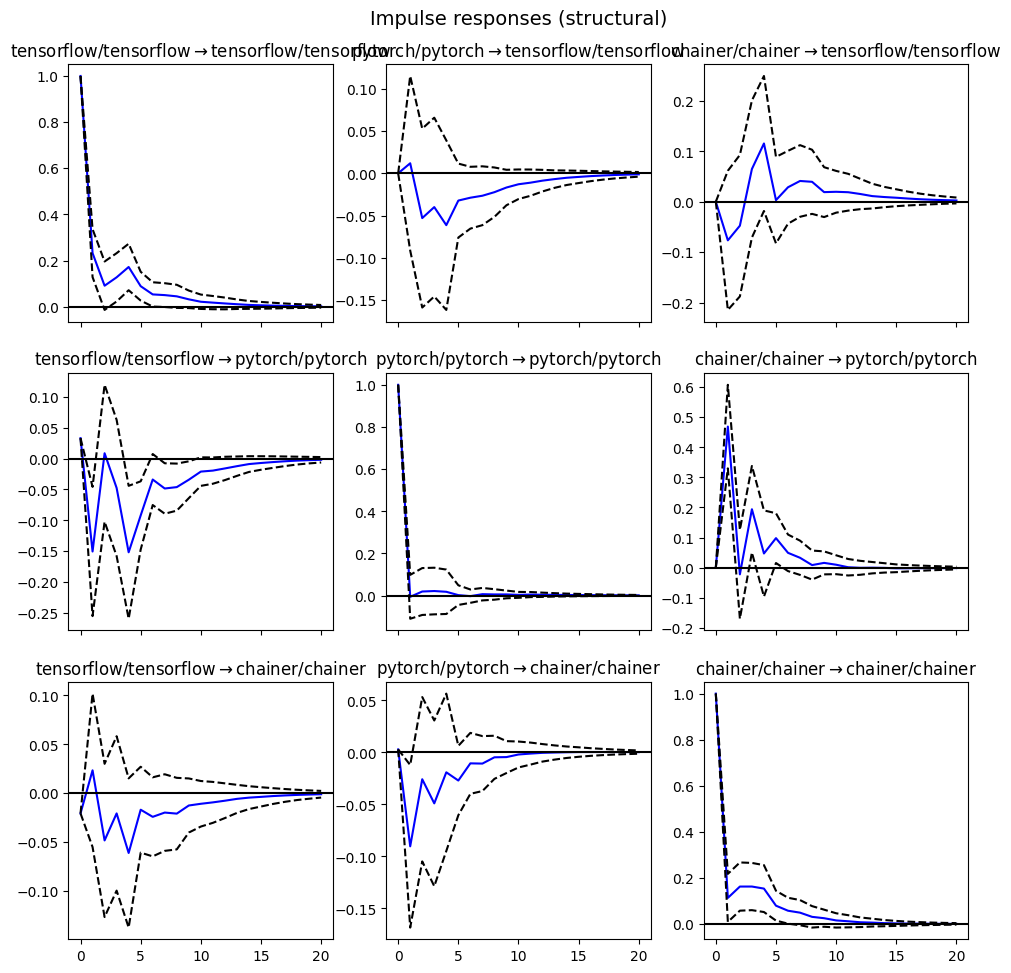

In [11]:
irf.plot();

## IRF Cum Effects

The cumulative impulse response can be obtained from `irf.svar_cum_effects`. The shape of it is same as svar_irfs. 

Similar to the regular IRF, you can plot the graph using `irf.plot_cum_effects()`. However, it is important to note that this graph shows the cumulative impulse responses based on the standard reduced-form VAR, not the SVAR-based impulse responses. Nevertheless, we will create this plot as an example to examine the shape of the cumulative impulse responses.

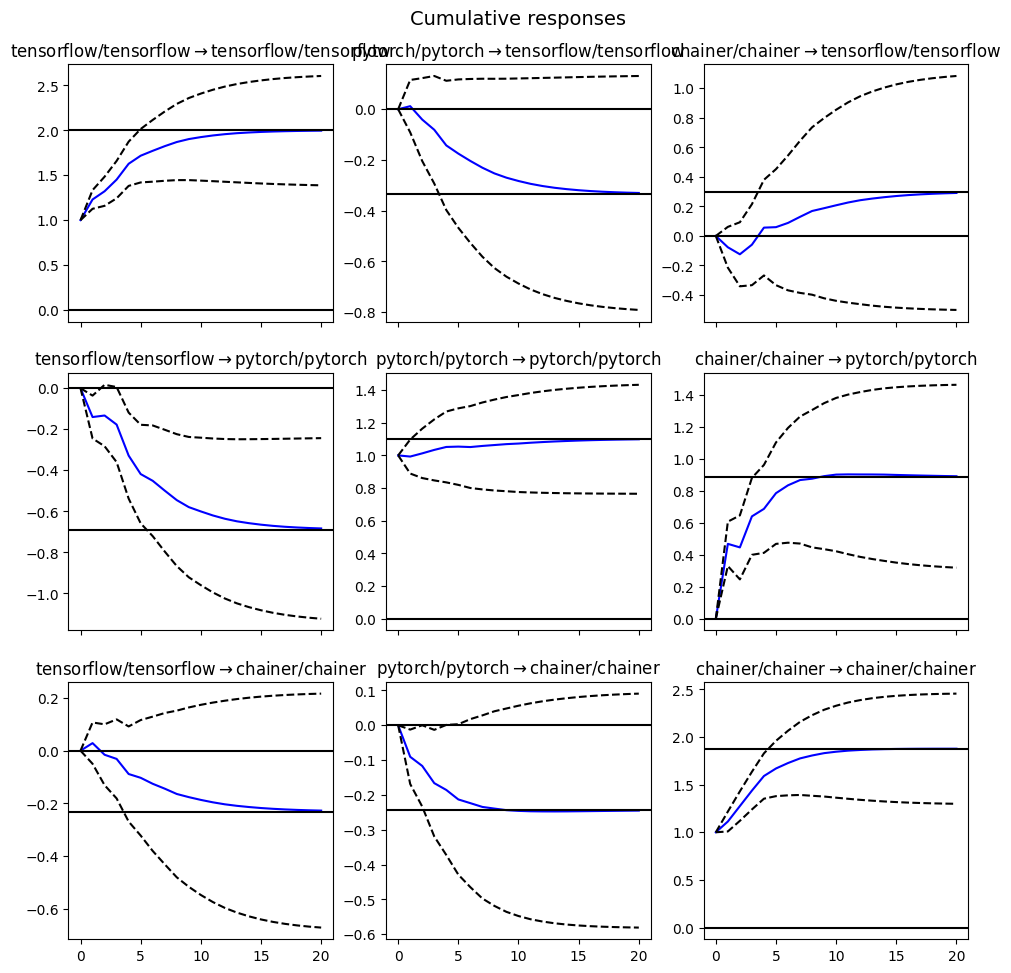

In [12]:
irf.plot_cum_effects();

In [13]:
irf.svar_cum_effects.shape

(21, 3, 3)

In [14]:
# svar_cum_effects of tensorflow -> tensorflow
irf.svar_cum_effects[:, 0, 0]

array([1.        , 1.23209311, 1.32281255, 1.44993998, 1.62188274,
       1.71054006, 1.76355165, 1.81356709, 1.85822927, 1.88993827,
       1.91113235, 1.92857537, 1.94240705, 1.95292282, 1.96040789,
       1.96618366, 1.97062425, 1.97398535, 1.97644727, 1.97829372,
       1.97968933])

In [15]:
# svar_cum_effects of pytorch -> chainer
irf.svar_cum_effects[:, 2, 1]

array([ 0.00289877, -0.08735999, -0.11313719, -0.16210622, -0.18121532,
       -0.20823603, -0.21873767, -0.22945427, -0.23413172, -0.23860466,
       -0.24059003, -0.24170206, -0.24208155, -0.24215069, -0.24196191,
       -0.24158884, -0.24119287, -0.2407793 , -0.24039272, -0.24002704,
       -0.23970762])

The last index of irf.svar_cum_effects corresponds to the SCE (Shock Cumulative Effect) between each pair of OSS.

In [16]:
irf.svar_cum_effects[-1]

array([[ 1.97968933, -0.32951079,  0.29104438],
       [-0.66598033,  1.10125866,  0.89208772],
       [-0.2748264 , -0.23970762,  1.8767399 ]])

# MIAO Score Calculation

MIAO Score definition. 

$$
\mathrm{MS}_{ij} = (-1) \cdot \sum_{k=1}^m \mathrm{SCE}_{ij}^k
$$

In [17]:
shifts = ["original", "1_month_shifted", "2_month_shifted", "3_month_shifted"]
Tms = ["T1", "T2", "T3", "T4"]
group_with_sep = "1_0"
permutation_id = "0"

sces_with_shifts, _, _ = miao_phase1_with_period_shifts(A, shifts, Tms, group_with_sep, permutation_id)

## MIAO Score Table

This result matches the corresponding csv results under the `miao_score_tables` directory

In [18]:
miao_score_table = miao_phase2_with_period_shifts(sces_with_shifts)
display(miao_score_table)

,AMS_ij
pytorch/pytorch -> tensorflow/tensorflow,-3.076139
chainer/chainer -> tensorflow/tensorflow,-3.578543
tensorflow/tensorflow -> pytorch/pytorch,-0.117943
chainer/chainer -> pytorch/pytorch,-0.983100
tensorflow/tensorflow -> chainer/chainer,-0.815324
pytorch/pytorch -> chainer/chainer,2.118299


In [19]:
# For Example, miao_score_tables/1_0.csv matches above table.
pd.read_csv("./miao_score_tables/permute_0/1_0.csv", index_col=0)

,AMS_ij
pytorch/pytorch -> tensorflow/tensorflow,-3.076139
chainer/chainer -> tensorflow/tensorflow,-3.578543
tensorflow/tensorflow -> pytorch/pytorch,-0.117943
chainer/chainer -> pytorch/pytorch,-0.983100
tensorflow/tensorflow -> chainer/chainer,-0.815324
pytorch/pytorch -> chainer/chainer,2.118299


# Decision Tree

Training and Performance Evaluation of Decision Tree Model Using datasets/decisiontree/{permute_i}.csv

In [20]:
params = {
    'max_depth': 3, 
    'min_samples_split': 10, 
    'min_samples_leaf': 5,
    'random_state': 42
}

decision_tree_df_permutes = [
    pd.read_csv("./datasets/decisiontree/permute_0.csv"),
    pd.read_csv("./datasets/decisiontree/permute_1.csv"),
    pd.read_csv("./datasets/decisiontree/permute_2.csv"),
    pd.read_csv("./datasets/decisiontree/permute_3.csv"),
    pd.read_csv("./datasets/decisiontree/permute_4.csv"),
    pd.read_csv("./datasets/decisiontree/permute_5.csv"),
]

classifier_results_permutes = []

for i, decision_tree_df in enumerate(decision_tree_df_permutes):
    data = decision_tree_df
    X = data.drop(['label', 'group', 'target'], axis=1)
    y = data['label']
    
    cv_scores = []
    y_preds = []
    
    loo = LeaveOneOut()
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
        clf = DecisionTreeClassifier(**params)
        clf.fit(X_train, y_train)
    
        y_pred = clf.predict(X_test)
        cv_scores.append(accuracy_score(y_test, y_pred))
        y_preds.append(y_pred[0])
    
    cv_scores = np.array(cv_scores)
    confidence_level = 0.95
    degrees_of_freedom = len(cv_scores) - 1
    sample_mean = np.mean(cv_scores)
    sample_standard_error = stats.sem(cv_scores)
    
    ci_low, ci_high = stats.t.interval(confidence_level, degrees_of_freedom, 
                                       loc=sample_mean, 
                                       scale=sample_standard_error)

    print(f"------ Classification Report; Set {i+1} ------ ")
    
    print(f"Sample size: {len(y)}")
    print(f"Mean accuracy: {cv_scores.mean():.4f}")
    print(f"Standard deviation of accuracy: {cv_scores.std():.4f}")
    print(f"95% confidence interval: ({ci_low:.4f}, {ci_high:.4f})")
    
    print("")
    print(classification_report(y, y_preds, target_names=["nonREV", "REV"]))

    classifier_results_permutes.append((y_preds, X, y))

------ Classification Report; Set 1 ------ 
Sample size: 67
Mean accuracy: 0.8209
Standard deviation of accuracy: 0.3834
95% confidence interval: (0.7267, 0.9151)

              precision    recall  f1-score   support

      nonREV       0.90      0.74      0.81        35
         REV       0.76      0.91      0.83        32

    accuracy                           0.82        67
   macro avg       0.83      0.82      0.82        67
weighted avg       0.83      0.82      0.82        67

------ Classification Report; Set 2 ------ 
Sample size: 67
Mean accuracy: 0.7463
Standard deviation of accuracy: 0.4351
95% confidence interval: (0.6393, 0.8532)

              precision    recall  f1-score   support

      nonREV       0.78      0.71      0.75        35
         REV       0.71      0.78      0.75        32

    accuracy                           0.75        67
   macro avg       0.75      0.75      0.75        67
weighted avg       0.75      0.75      0.75        67

------ Classificat

# Exports feature importance for DecisionTree

In [21]:
graphs = []
feature_importance_dfs = []

for i, (y_preds, X, y) in enumerate(classifier_results_permutes):
    clf = DecisionTreeClassifier(**params)
    clf.fit(X, y)

    dot_data = export_graphviz(clf, feature_names=X.columns, class_names=["nonREV", "REV"], filled=True)
    graph = graphviz.Source(dot_data)
    graphs.append(graph)

    feature_importance_df = pd.DataFrame({
        'feature_importance': clf.feature_importances_,
    }, index=X.columns).sort_values(by='feature_importance', ascending=True)
    feature_importance_dfs.append(feature_importance_df)

In [22]:
# Uncomment to view the decision tree.
# for graph in graphs:
#     display(graph)

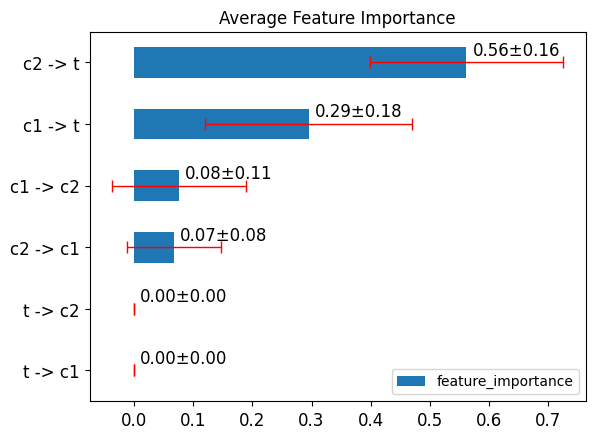

In [23]:
for i, df in enumerate(feature_importance_dfs, 1):
    df.columns = [f"imp_{i}"]
    
combined = pd.concat(feature_importance_dfs, axis=1)

mean_series = combined.mean(axis=1)
std_series  = combined.std(axis=1)

summary = pd.DataFrame({
    "feature_importance": mean_series,
    "std": std_series
}).sort_values(by='feature_importance', ascending=True)

ax = summary[["feature_importance"]].plot.barh(
        xerr=summary["std"],
        error_kw={
            "ecolor": "red",
            "capsize": 4,
            "elinewidth": 1
        },    
        capsize=5,
        color="tab:blue",
        fontsize=12,
        legend=True
);

ax.set_title("Average Feature Importance")

for i, (val, err) in enumerate(zip(summary["feature_importance"], summary["std"])):
    ax.text(
        val + 0.01,
        i+0.2,
        f"{val:.2f}±{err:.2f}",
        va="center",
        fontsize=12
    )

## Relative AMS error for each set and Friedman test

$$
\mathrm{RAE} = \frac{\bigl|\mathrm{AMS}_{\mathrm{Set}k}(i\to j)-\mathrm{AMS}_{\mathrm{Set}3}(i\to j)\bigr|}{\bigl|\mathrm{AMS}_{\mathrm{Set}3}(i\to j)\bigr|}\times100\%
$$

In [24]:
ams_dfs = {}

non_normalized_decision_tree_df_permutes = [
    pd.read_csv("./datasets/decisiontree/non-normalized/permute_0.csv"),
    pd.read_csv("./datasets/decisiontree/non-normalized/permute_1.csv"),
    pd.read_csv("./datasets/decisiontree/non-normalized/permute_2.csv"),
    pd.read_csv("./datasets/decisiontree/non-normalized/permute_3.csv"),
    pd.read_csv("./datasets/decisiontree/non-normalized/permute_4.csv"),
    pd.read_csv("./datasets/decisiontree/non-normalized/permute_5.csv"),
]

for i, df in enumerate(non_normalized_decision_tree_df_permutes):
    df = df[df.label == 0]
    ams_dfs[f"Set{i+1}"] = df[["c2 -> c1", "t -> c1", "c1 -> c2", "t -> c2", "c1 -> t", "c2 -> t"]] 
    
mean_ams = {set_name: df.mean() for set_name, df in ams_dfs.items()}
mean_df = pd.DataFrame(mean_ams)

baseline = mean_df['Set3'].abs()
rel_error = (mean_df.subtract(mean_df['Set3'], axis=0)
                     .abs()
                     .div(baseline, axis=0) * 100)

rel_error = rel_error[['Set1', 'Set2', 'Set3', 'Set4', 'Set5', 'Set6']]
rel_error = rel_error.round(1)
rel_error.index.name = 'Direction (i→j)'

display(rel_error)

all_rel = []
for set_name, df in ams_dfs.items():
    tmp = df.stack().reset_index()
    tmp.columns = ['group','direction', set_name]
    all_rel.append(tmp)

long = all_rel[0]
for tmp in all_rel[1:]:
    long = long.merge(tmp, on=['group','direction'])

stat, p = stats.friedmanchisquare(
    long['Set1'],
    long['Set2'],
    long['Set3'],
    long['Set4'],
    long['Set5'],
    long['Set6']
)

print(f"Friedman χ² = {stat:.3f}, p = {p:.3f}")

,Set1,Set2,Set3,Set4,Set5,Set6
Direction (i→j),,,,,,
c2 -> c1,32.3,69.8,0.0,71.7,2.8,74.2
t -> c1,71.7,75.0,0.0,29.3,2.2,68.9
c1 -> c2,28.6,126.5,0.0,237.9,5.9,196.0
t -> c2,64.7,59.9,0.0,41.5,56.0,44.7
c1 -> t,258.9,214.4,0.0,36.6,6.2,140.6
c2 -> t,128.2,158.6,0.0,31.1,77.4,25.2


Friedman χ² = 0.457, p = 0.994


## McNemar's Test for Classification results

In [25]:
set3 = pd.read_csv("classification_results/permute_2.csv")
set5 = pd.read_csv("classification_results/permute_4.csv")

y_true = set3.rev
y_pred_a = set5.predicted
y_pred_b = set3.predicted

a = np.sum((y_pred_a == y_true) & (y_pred_b == y_true))
b = np.sum((y_pred_a == y_true) & (y_pred_b != y_true))
c = np.sum((y_pred_a != y_true) & (y_pred_b == y_true))
d = np.sum((y_pred_a != y_true) & (y_pred_b != y_true))

table = np.array([[a, b],[c, d]])
print("Contingency Table:")
print("           B correct   B wrong")
print(f"A correct     {a:3d}         {b:3d}")
print(f"A wrong       {c:3d}         {d:3d}\n")

result = mcnemar(table, exact=True)
print(f"statistic = {result.statistic:.3f}")
print(f"p-value   = {result.pvalue:.3f}")

Contingency Table:
           B correct   B wrong
A correct      42           5
A wrong        17           3

statistic = 5.000
p-value   = 0.017
